/bin/sh: 1: LSS_BSK_calc: not found
/bin/sh: 1: LSS_BSK_calc: not found
/bin/sh: 1: LSS_BSK_calc: not found
/bin/sh: 1: LSS_BSK_calc: not found


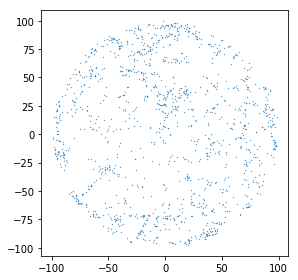

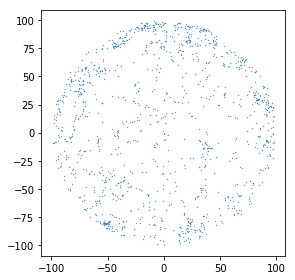

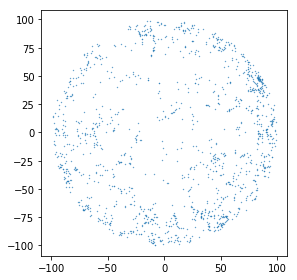

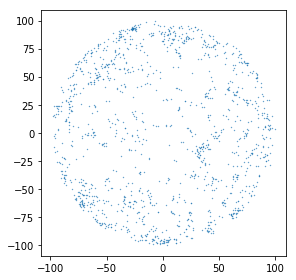

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def sph_random_point(Radius):
    u = np.random.rand()
    x1 = np.random.normal()
    x2 = np.random.normal()
    x3 = np.random.normal()
    
    norm = np.sqrt( x1**2 + x2**2 + x3**2)
    x1 /= norm
    x2 /= norm
    x3 /= norm
    
    r = Radius * u ** (1/3)
    
    return  [r*x1,r*x2,r*x3] 

# Download data files from the repo forero/abacus
urlpath = "https://raw.githubusercontent.com/"
urlpath += "forero/abacus/master/data/"
urlpath += "AbacusCosmos_1100box_00_FoF_halos_z0.300/cuts/"

# Create figures folder
fig_path = "./figures/"
!mkdir -p figures

# Create Random Catalog folder
rc_path = "./random_catalogs/"
!mkdir -p random_catalogs

# Create Observed Catalog folder
oc_path = "./observed_catalogs/"
!mkdir -p observed_catalogs

# Create Full Catalog folder
fc_path = "./full_catalogs/"
!mkdir -p full_catalogs

# To run at home
Manual_limit = 4

# Check how we are going at this file.
!touch progress.txt

# Some data parameters to start
delta_center = 200
radius = 100
cut =0 
for center_i in [-2,-1,0,1,2]:
    for center_j in [-2,-1,0,1,2]:
        for center_k in [-2,-1,0,1,2]:
            center_x = center_i * delta_center
            center_y = center_j * delta_center
            center_z = center_k * delta_center

            if( cut < Manual_limit):
                
                #############################################################
                #                                                           #
                #                   Download the datafiles                  #
                #                                                           #
                #############################################################
                
                filename = "sphere_data_cut_{}.dat".format(cut)
                file = str(urlpath)+str(filename)
                ! wget $file
                ! mv $filename $oc_path

                ## Read the file
                OC = np.loadtxt(oc_path + filename)
                            
                ## Number of observations.
                N_obs = OC.shape[0]
                
                ## Center of Data
                center = np.array([center_x,center_y,center_z])
               
                ## Move to Center of Data Coord. Syst. 
                r_list = []
                r_max  = 0
                for i in range(N_obs):
                    OC[i] = OC[i] - center

                    r = 0
                    for j in range(3):
                           r += OC[i,j]**2
                    r = r**0.5
                    r_list.append(r)
                    if r > r_max:
                        r_max = r

                r_list = np.array(r_list)
                

                # Checking outer shell.
                fig, ax = plt.subplots()
                index = np.where(r_list> 0.95*r_max )[0]
                plt.scatter( OC[index,1], OC[index,0], s=0.1)
                ax.set_aspect(1.0)
                plt.tight_layout()
                
                plt.savefig(fig_path+"outer_shell_cut_{}.pdf".format(cut))              

                
                #############################################################
                #                                                           #
                #     Generate 2N Random Catalog (R = 0.95 r_max)           #
                #                                                           #
                #############################################################
                
                ### Using the cut as seed
                np.random.seed(cut)

                ### A sigthly smaller radius to avoid surface percolation.
                R_rc = radius * 0.95

                ### Create Random Catalog
                RC = np.zeros([2*N_obs,3])
                for x in RC:
                    x += sph_random_point(R_rc)
                np.savetxt(rc_path + "rnd_sph_cat_R{}_cut_{}.cat".format(R_rc,cut), RC)

                # Create the full catalog (to calculate Beta Skeleton Graph)
                FC = np.vstack([RC,OC])
                FC_filename = fc_path + "FC_CUT_{}.cat".format(cut)
                np.savetxt(FC_filename, FC)

                
                #############################################################
                #                                                           #
                #     Run Xiao-Dong Li's Beta Skeleton Calculator           #
                #                                                           #
                #############################################################
                
                !LSS_BSK_calc -input  $FC_filename -output $cut -beta 1.0 -printinfo True -numNNB 300

                
                ! $cut >> progress.txt
                
            cut += 1 
    